In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

### Plot Gaussian

In [2]:
from matplotlib.patches import Ellipse    
        
def plot_gaussian(mus, sigmas, ax, weights = None):
    K = len(mus)
    if weights is None:
        weights = np.ones(K)/K
    
    for k in range(len(mus)):
        sigma = sigmas[k]
        val,vec = np.linalg.eig(sigma)
        angle = np.arctan2(vec[0,1], vec[0,0])
        ells = Ellipse(xy=mus[k],
                width=4.*np.sqrt(val[0]), height=4.*np.sqrt(val[1]),
                angle=np.rad2deg(angle))
        #ells.set_clip_box(a.bbox)
        ells.set_alpha(weights[k])
        ax.add_artist(ells)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    return

### Generate Data

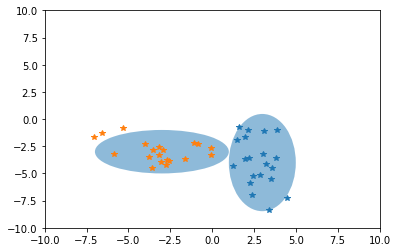

In [3]:
D = 2
mu1 = np.array([3., -4.])
sigma1 = np.diag([1., 5.])

mu2 = np.array([-3., -3.])
sigma2 = np.diag([4., 1.])

N = 40

sample1 = np.random.multivariate_normal(mu1, cov = sigma1, size = N/2)
sample2 = np.random.multivariate_normal(mu2, cov = sigma2, size = N/2)
samples = np.vstack([sample1, sample2])
fig,ax = plt.subplots()
plot_gaussian([mu1,mu2],[sigma1,sigma2],ax)
plt.plot(sample1[:,0],sample1[:,1],'*')
plt.plot(sample2[:,0],sample2[:,1],'*')


### Gaussian Mixture Model

In [4]:
import time

In [5]:
K = 3
pis = np.ones(K)/K
mus = np.random.rand(K,D)
sigmas = np.array([np.eye(D) for i in range(K)])
zs = np.zeros((N,K))

In [6]:
from IPython.display import clear_output
for j in range(20):    
    ###  E-Step
    for i in range(N):
        for k in range(K):
            zs[i,k] = pis[k]*mvn.pdf(samples[i,:],mus[k], sigmas[k])

        zs[i,:] = zs[i,:]/np.sum(zs[i,:])
    Ns = np.sum(zs,axis=0)

    ### M-Step
    for k in range(K):
        mus[k,:] = np.dot(zs[:,k].T, samples)/Ns[k]
        sigma_k = np.zeros((D,D))
        for i in range(N):
            sigma_k += zs[i,k]*np.outer(samples[i,:]-mus[k,:], samples[i,:].T-mus[k,:].T)
        sigma_k /= Ns[k]
        sigmas[k,:] = sigma_k
        pis[k] = Ns[k]/N 
    print mus
    
    plot_gaussian(mus,sigmas,pis)
    plt.plot(sample1[:,0],sample1[:,1],'r*',zorder = 0)
    plt.plot(sample2[:,0],sample2[:,1],'y*',zorder = 0)
    plt.show()
    #raw_input()
    clear_output(wait=True)
    
    time.sleep(0.1)


[[ 1.8107879  -4.03195837]
 [-0.96843402 -3.01080916]
 [-3.013334   -2.77695737]]


AttributeError: 'numpy.ndarray' object has no attribute 'add_artist'

### Bayesian Gaussian Mixture 

In [ ]:
from sklearn.mixture import BayesianGaussianMixture

In [ ]:
bgmm = BayesianGaussianMixture(n_components=4, n_init=5)
bgmm.fit(samples)
plot_gaussian(bgmm.means_, bgmm.covariances_, bgmm.weights_)
plt.plot(sample1[:,0],sample1[:,1],'r*',zorder = 0)
plt.plot(sample2[:,0],sample2[:,1],'y*',zorder = 0)

### Implement different techniques: MCMC sampling, Laplace Approximations, and Gaussian Variational Approximations 

### Generate Data

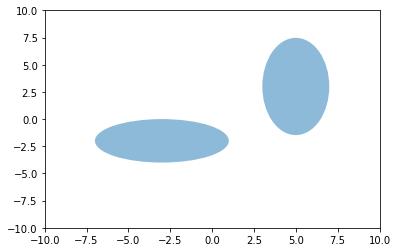

In [7]:
import numpy as np
import matplotlib.pyplot as plt
D = 2
K = 4
mu1 = np.array([5., 3.])
sigma1 = np.diag([1., 5.])

mu2 = np.array([-3., -2.])
sigma2 = np.diag([4., 1.])

N = 10

sample1 = np.random.multivariate_normal(mu1, cov = sigma1, size = N/4)
sample2 = np.random.multivariate_normal(mu2, cov = sigma2, size = 3*N/4)
samples = np.vstack([sample1, sample2])
fig,ax = plt.subplots()
plot_gaussian([mu1,mu2],[sigma1,sigma2],ax)
#plt.hist(sample1)
#plt.hist(sample2)


In [8]:
from scipy.stats import multivariate_normal as mvn
from scipy.stats import dirichlet, invwishart, wishart
from tensorflow_probability import distributions as tfd



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [9]:
import tensorflow as tf

In [10]:
sess = tf.InteractiveSession()


In [11]:
def log_gaussian_prior(mu_0 = tf.zeros(D), sigma_0 = tf.eye(D)):
    func = lambda mu: tfd.MultivariateNormalFullCovariance(loc=mu_0, covariance_matrix = sigma_0).log_prob(mu)
    return func
    
def log_dirichlet_prior(alphas = tf.ones(K)/K):
    def func( pis):
        return tfd.Dirichlet(alphas).log_prob(pis)
    return func
    
def log_wishart_prior(df = D, scale = tf.eye(D)):
    func = lambda sigma: tfd.Wishart(df,scale).log_prob(sigma)
    return func

In [12]:
def log_joint_prior():
    log_prior_mu  = log_gaussian_prior()
    log_prior_pis = log_dirichlet_prior()
    log_prior_sigma = log_wishart_prior()
    func = lambda mus, sigmas, pis: np.sum([log_prior_mu(mu) for mu in mus]) + log_prior_pis(pis) + np.sum([log_prior_sigma(sigma) for sigma in sigmas])
    return func

def log_likelihood(x):
    func = lambda mus, sigmas, pis: tf.log(tf.reduce_sum([pis[k]*tfd.MultivariateNormalFullCovariance(mus[k], sigmas[k]).prob(x) for k in range(len(pis))]))
    return func
    
def log_posterior(data):
    log_prior = log_joint_prior()
    
    def func(theta):
        mus, sigmas, pis = theta[0], theta[1], theta[2]
        val = log_prior(mus, sigmas, pis)
        print val.dtype
        for x in data:
            print 'yes'
            log_likelihood_datapoint = log_likelihood(x)
            b = log_likelihood_datapoint(mus, sigmas, pis)
            b = tf.cast(b,tf.float32)
            val = val + b#log_likelihood_datapoint(mus, sigmas, pis)
        
        return val
    
    return func

### Plotting the cross-section of the posteriors

In [15]:
sigmas = np.array([np.eye(D), np.eye(D),np.eye(D),np.eye(D)])
mus = np.array([np.array([10., 10.]), np.array([-10., -10.]),np.array([5., 10.]), np.array([-10., -5.])])
pis = np.array([0.25, 0.25,0.25, 0.25])
theta0 = [mus, sigmas, pis]

In [16]:
sigmas_true = np.array([sigma1, sigma2])
mus_true = np.array([mu1, mu2])
pis_true = np.array([0.25, 0.75])

log_posterior_data = log_posterior(samples)

In [19]:
post = log_posterior_data(theta0)

<dtype: 'float32'>
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [24]:
post.eval(feed_dict={''})

-727.9974

In [16]:
def random_move(theta, lamda = 0.05):
    mus, sigmas, pis = np.copy(theta[0]), np.copy(theta[1]), np.copy(theta[2])
    for k in range(len(mus)):
        delta_mu = lamda*mvn.rvs(mean=np.zeros(D))
        mus[k] += delta_mu
        
        sigmas[k] = invwishart.rvs(df = 600., scale = 600*sigmas[k])
        #sigmas[k] += delta_sigma
        #sigmas[k]  = np.exp(np.log(sigmas[k]) + 2*lamda*np.random.normal())
        
        delta_pis = lamda*dirichlet.rvs(np.ones(K)/K).flatten()
        pis += delta_pis
    
    pis = pis / np.sum(pis)
    
    return [mus, sigmas, pis]

### Do MCMC on the unnormalized posterior

In [450]:
def MH_sampling(func,theta0, n = 1000, lamda= 0.05):
    samples = [theta0]
    cur_theta = theta0
    accept_num = 0
    for i in range(n):
        cur_func_value = func(cur_theta)
        #Proposal distribution
        new_theta = random_move(cur_theta,lamda)

        new_func_value = func(new_theta)

        #decide whether to accept or reject
        accept_threshold = np.exp(new_func_value-cur_func_value)

        random_num = np.random.rand()
        if random_num < accept_threshold: #equivalent to the above
            samples.append(new_theta)
            cur_theta = new_theta
            accept_num += 1
            print 'accept'
        else:
            samples.append(cur_theta)
            
        if i%10 == 0: print i
    
    return (samples), 1.0*accept_num/n

In [452]:
from IPython.display import clear_output

In [453]:
posterior_samples, success_rate = MH_sampling(log_posterior_data, theta0, n = 4000, lamda = 0.1)
clear_output()
print success_rate

0.02925


In [454]:
samples_mus = []
samples_sigmas = []
samples_pis = []

for sample in posterior_samples:
    samples_mus.append(sample[0])
    samples_sigmas.append(sample[1])
    samples_pis.append(sample[2])

In [455]:
print np.mean(np.array(samples_mus[2000:]), axis=0)

print np.mean(np.array(samples_sigmas[2000:]), axis=0)

print np.mean(np.array(samples_pis[2000:]), axis=0)

print mu1, mu2

print sigma1, sigma2

[[ 9.4798732   9.71124622]
 [-9.86184596 -9.50564643]
 [ 4.51188032  6.57828327]
 [-6.51560007 -3.21434003]]
[[[ 0.29761399  0.1037639 ]
  [ 0.1037639   1.44513816]]

 [[ 1.13379088  0.52366492]
  [ 0.52366492  2.01064631]]

 [[ 0.63994865  0.95664691]
  [ 0.95664691  4.69362593]]

 [[47.27229626 15.42335304]
  [15.42335304  6.3373299 ]]]
[0.06180786 0.05401991 0.13955565 0.74461658]
[5. 3.] [-3. -2.]
[[1. 0.]
 [0. 5.]] [[4. 0.]
 [0. 1.]]


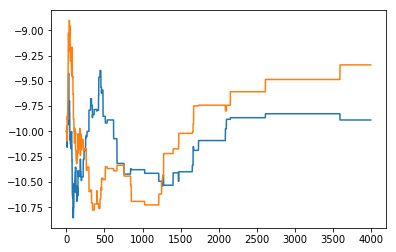

In [456]:
plt.plot(np.array(samples_mus)[:,1])

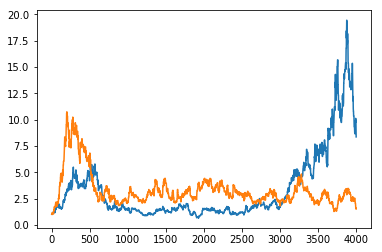

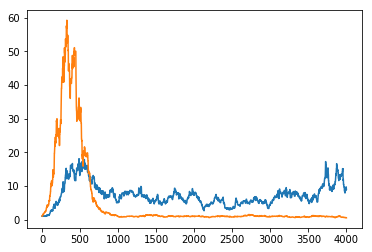

In [396]:
plt.figure()
plt.plot(np.array(samples_sigmas)[:,:,0,0])
plt.figure()
plt.plot(np.array(samples_sigmas)[:,:,1,1])

In [397]:
posterior_samples = posterior_samples[2000:]

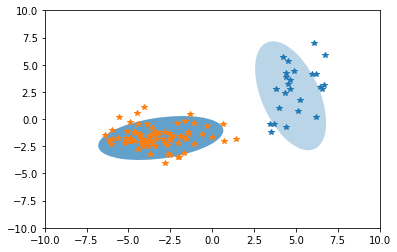

In [433]:
fig, ax = plt.subplots()
plt.plot(sample1[:,0],sample1[:,1],'*')
plt.plot(sample2[:,0],sample2[:,1],'*')
for i in range(1):
    index = np.random.randint(len(posterior_samples))
    sample = posterior_samples[index]
    mus, sigmas, pis = sample[0], sample[1], sample[2]
    plot_gaussian(mus,sigmas,ax,pis)
    
plt.show()

In [382]:
samples

array([[ 5.25376301e+00,  7.41959325e+00],
       [ 5.43632133e+00,  1.78844386e+00],
       [ 7.21531225e+00,  3.87524463e+00],
       [ 5.57769982e+00,  7.37318911e-01],
       [ 4.70028621e+00,  9.35727964e-01],
       [ 4.39008600e+00,  4.69068283e+00],
       [ 6.98331713e+00, -7.76986072e-01],
       [ 5.30648041e+00,  4.01401220e+00],
       [ 3.90801794e+00,  4.23397214e+00],
       [ 4.08152317e+00,  3.91564312e+00],
       [ 5.68001541e+00,  4.47426930e+00],
       [ 4.38769674e+00,  5.13474419e+00],
       [ 5.58540342e+00,  2.52211282e+00],
       [ 5.48652080e+00,  5.41210283e+00],
       [ 6.32155880e+00,  7.71076940e+00],
       [ 6.26227205e+00,  2.20632650e+00],
       [ 5.26530499e+00,  1.88581915e+00],
       [ 4.05551137e+00,  4.11604455e+00],
       [ 4.26654055e+00,  3.68700494e+00],
       [ 4.44987256e+00,  2.83748984e+00],
       [ 4.68845182e+00,  2.19415601e+00],
       [ 5.52601439e+00, -2.17683160e-01],
       [ 3.66179426e+00,  1.42540319e+00],
       [ 5.